# Data Gathering

## Process
1. Understand how audio is processed
2. Determine what features to extract from the audio signal
3. Understand what each feature represents and how it is calculated
4. Write a function that reads and extracts important numeric features from audio signals from a given directory
5. Write a function that reads audio signals and extracts the mel spectrograms 

**IMPORTANT NOTE:** after downloading the data from http://marsyas.info/downloads/datasets.html, I combined all of the files into a single folder and named it "wavfiles." Make sure to do this if you are going through this notebook, and place the "wavfiles" folder in the empty "data" folder.

## Tests with Single Audio File (Toy Example)

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

### Extracting an Audio Signal

A **signal** is a variation in a quantity over time. For audio, the quantity that varies is air pressure. We can represent a signal digitally by taking samples of the air pressure over time. We are left with a waveform for the signal. Librosa is a python library that allows us to extract waveforms from audio files along with several other features. This is the primary package that will be used for this project.

In [2]:
# Extracting the wave, "y", and sampling rate, "sr", of the audio file
#y, sr = librosa.load('../data/wavfiles/blues.00000.wav')
y, sr = librosa.load('../data/wavfiles/pop.00000.wav')

In [3]:
# Checking the shape of the wave
y.shape

(661504,)

In [4]:
# Checking the sampling rate
sr

22050

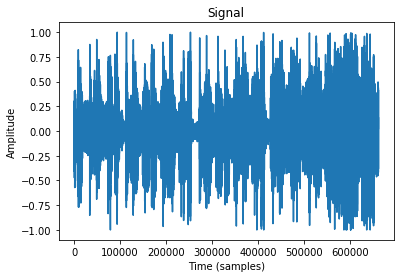

In [5]:
# Plotting the wave
plt.plot(y);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');

### Fast Fourier Transform (FFT)

An audio signal is comprised of several single-frequency sound waves. When taking samples of the signal over time, we only capture the resulting amplitudes. The **Fourier transform** is a mathematical formula that allows us to decompose a signal into it’s individual frequencies and the frequency’s amplitude. In other words, it converts the signal from the time domain into the frequency domain. The result is called a **spectrum**. The **fast Fourier transform** is an efficient way to compute the Fourier transform.

![](../images/fourier_transform.png)
citation: https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520

In [6]:
# Computing the fast Fourier transform on a single short time window of length 2048 (standard for music audio)
n_fft = 2048
ft = np.abs(librosa.stft(y[:n_fft], hop_length = n_fft+1))

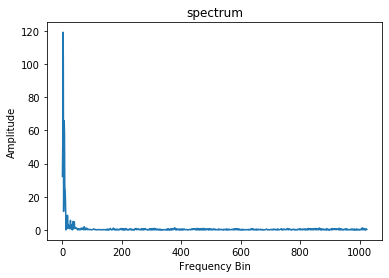

In [7]:
# Plotting the signal after applying the FFT
plt.plot(ft);
plt.title('spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');

### Mel Spectrograms

**Spectrograms** are a way to visually represent a signal's loudness, or amplitude, as it varies over time at different frequencies. The horizontal axis is time, the vertical axis is frequency, and the color is amplitude. It is calculated using the fast Fourier transform on short time windows of the signal and transforming the vertical axis (frequency) to log scale and the colored axis (amplitude) to decibals. Now, what about the "mel" part? Humans are better at detecting differences in lower frequencies than higher frequencies. The **mel scale** transforms the frequency scale such that sounds at equal distances from each other also sound equal in distance. A **mel spectrogram** is a spectrogram where the frequencies are converted to the mel scale.  

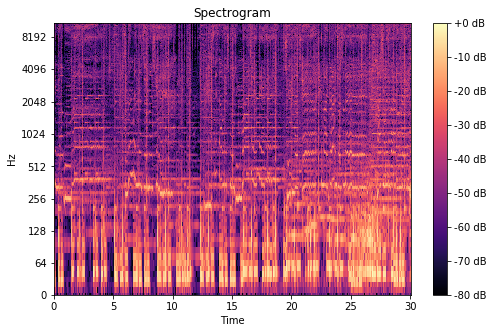

In [8]:
# Computing the spectrogram
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max) # converting to decibals

# Plotting the spectrogram
plt.figure(figsize=(8,5));
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

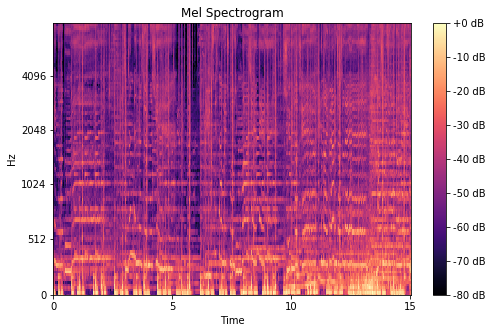

In [9]:
# Computing the mel spectrogram
spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
spect = librosa.power_to_db(spect, ref=np.max) # Converting to decibals

# Plotting the mel spectrogram
plt.figure(figsize=(8,5))
librosa.display.specshow(spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

### Mel Frequency Cepstral Coefficients (MFCC)
MMCCs are commonly used features in the field of music information retrieval (MIR). They are tyically used to measure timbre. 

In [10]:
# Extracting mfccs from the audio signal
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)

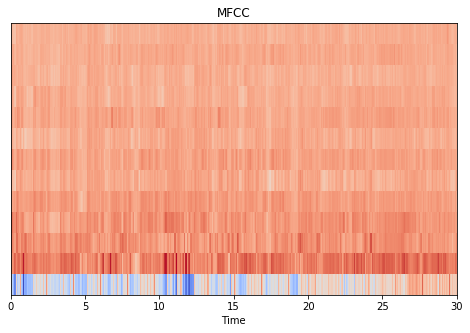

In [11]:
# Displaying the mfccs
plt.figure(figsize=(8,5));
librosa.display.specshow(mfcc, x_axis='time');
plt.title('MFCC');

In [12]:
# Scaling the mfccs
mfccscaled = np.mean(mfcc.T, axis=0)
mfccscaled

array([-94.47738  ,  55.655693 ,  29.277376 ,  27.05505  ,  20.05898  ,
         1.1853248,  12.943359 ,  -0.7949456,   8.872685 ,  -0.681623 ,
        -5.346009 ,   2.2020652,  -4.618987 ], dtype=float32)

## Function to Read and Extract Mel Spectrograms from Audio Files

#### Checking the Size of the Mel Spectrograms
In order to feed the mel spectrogram data into a neural network, they must all be the same size, so I check that here. 

In [13]:
# Creating an empty list to store sizes in
sizes = []

# Looping through each audio file
for file in os.scandir('../data/wavfiles'):
        
    # Loading in the audio file
    y, sr = librosa.core.load(file)
        
    # Computing the mel spectrograms
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    
    # Adding the size to the list
    sizes.append(spect.shape)
    
# Checking if all sizes are the same
print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

# Checking the max size
print(f'The maximum size is: {max(sizes)}')

The sizes of all the mel spectrograms in our data set are equal: False
The maximum size is: (128, 660)


**Note:** The Sizes are not the same, so we will have to pad the smaller arrays with zeros to make them all the same size.

In [14]:
def extract_mel_spectrogram(directory):
    '''
    This function takes in a directory of audio files in .wav format, computes the
    mel spectrogram for each audio file, reshapes them so that they are all the 
    same size, and stores them in a numpy array. 
    
    It also creates a list of genre labels and maps them to numeric values.
    
    Parameters:
    directory (int): a directory of audio files in .wav format
    
    Returns:
    X (array): array of mel spectrogram data from all audio files in the given
    directory
    y (array): array of the corresponding genre labels in numeric form
    '''
    
    # Creating empty lists for mel spectrograms and labels
    labels = []
    mel_specs = []
    
    # Looping through each file in the directory
    for file in os.scandir(directory):
        
        # Loading in the audio file
        y, sr = librosa.core.load(file)
        
        # Extracting the label and adding it to the list
        label = str(file).split('.')[0][11:]
        labels.append(label)
        
        # Computing the mel spectrograms
        spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
        spect = librosa.power_to_db(spect, ref=np.max)
        
        # Adjusting the size to be 128 x 660
        if spect.shape[1] != 660:
            spect.resize(128,660, refcheck=False)
            
        # Adding the mel spectrogram to the list
        mel_specs.append(spect)
        
    # Converting the list or arrays to an array
    X = np.array(mel_specs)
    
    # Converting labels to numeric values
    labels = pd.Series(labels)
    label_dict = {
        'classical': 1,
        'hiphop': 2,
        'jazz': 3,
        'metal': 4,
        'pop': 5,
        'rock': 6
    }
    y = labels.map(label_dict)
    
    # Returning the mel spectrograms and labels
    return X, y

In [15]:
# Using the function to read and extract mel spectrograms from the GTZAN Genre Dataset audio files
X, y = extract_mel_spectrogram('../data/wavfiles')

**Note:** I will use this function in the first CNN notebook to gather and preprocess the data.

## Function to Read and Extract Mel Spectrograms from Audio Files and Convert to DataFrame

In [16]:
def make_mel_spectrogram_df(directory):
    '''
    This function takes in a directory of audio files in .wav format, computes the
    mel spectrogram for each audio file, reshapes them so that they are all the 
    same size, flattens them, and stores them in a dataframe.
    
    Genre labels are also computed and added to the dataframe.
    
    Parameters:
    directory (int): a directory of audio files in .wav format
    
    Returns:
    df (DataFrame): a dataframe of flattened mel spectrograms and their 
    corresponding genre labels
    '''
    
    # Creating empty lists for mel spectrograms and labels
    labels = []
    mel_specs = []
    
    # Looping through each file in the directory
    for file in os.scandir(directory):
        
        # Loading in the audio file
        y, sr = librosa.core.load(file)
        
        # Extracting the label and adding it to the list
        label = str(file).split('.')[0][11:]
        labels.append(label)
        
        # Computing the mel spectrograms
        spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
        spect = librosa.power_to_db(spect, ref=np.max)
        
        # Adjusting the size to be 128 x 660  
        if spect.shape[1] != 660:
            spect.resize(128,660, refcheck=False)
        
        # Flattening to fit into dataframe and adding to the list
        spect = spect.flatten()
        mel_specs.append(spect)
        
    # Converting the lists to arrays so we can stack them
    mel_specs = np.array(mel_specs)
    # BUGFIX : Do Not Normalize labels but do calculate averages
    # valueerror: cannot reshape array of size ***into shape (1000, 1)
    # https://books.google.co.kr/books?id=P9G1DwAAQBAJ&pg=PA197&lpg=PA197&dq=labels+%3D+np.array(labels).reshape(1000,1)&source=bl&ots=C8VE8Uyygr&sig=ACfU3U0AwppJmEmECEOE1LtIOxrOfbZI6w&hl=en&sa=X&ved=2ahUKEwjm_8CVjs_pAhUJCpQKHQk6CBIQ6AEwAHoECAkQAQ#v=onepage&q=labels%20%3D%20np.array(labels).reshape(1000%2C1)&f=false
    #labels = np.array(labels).reshape(1000,1)    
    labels = np.array(labels).reshape([-1,1])  
    
    # Create dataframe
    df = pd.DataFrame(np.hstack((mel_specs,labels)))
    
    # Returning the mel spectrograms and labels
    return df

In [17]:
# Using the above function to create a dataframe with all of the flattened mel spectrograms and genre labels
df = make_mel_spectrogram_df('../data/wavfiles')

#### Export

In [18]:
df.to_csv('../data/genre_mel_specs.csv', index=False)

## Function to Read and Extract Numeric Features from Audio Files

In [19]:
def extract_audio_features(directory):
    '''
    This function takes in a directory of .wav files and returns a 
    DataFrame that includes several numeric features of the audio file 
    as well as the corresponding genre labels.
    
    The numeric features incuded are the first 13 mfccs, zero-crossing rate, 
    spectral centroid, and spectral rolloff.
    
    Parameters:
    directory (int): a directory of audio files in .wav format
    
    Returns:
    df (DataFrame): a table of audio files that includes several numeric features 
    and genre labels.
    '''
    
    # Creating an empty list to store all file names
    files = []
    labels = []
    zcrs = []
    spec_centroids = []
    spec_rolloffs = []
    mfccs_1 = []
    mfccs_2 = []
    mfccs_3 = []
    mfccs_4 = []
    mfccs_5 = []
    mfccs_6 = []
    mfccs_7 = []
    mfccs_8 = []
    mfccs_9 = []
    mfccs_10 = []
    mfccs_11 = []
    mfccs_12 = []
    mfccs_13 = []
    
    # Looping through each file in the directory
    for file in os.scandir(directory):
        
        # Loading in the audio file
        y, sr = librosa.core.load(file)
        
        # Adding the file to our list of files
        files.append(file)
        
        # Adding the label to our list of labels
        label = str(file).split('.')[0]
        labels.append(label)
        
        # Calculating zero-crossing rates
        zcr = librosa.feature.zero_crossing_rate(y)
        zcrs.append(np.mean(zcr))
        
        # Calculating the spectral centroids
        spec_centroid = librosa.feature.spectral_centroid(y)
        spec_centroids.append(np.mean(spec_centroid))
        
        # Calculating the spectral rolloffs
        spec_rolloff = librosa.feature.spectral_rolloff(y)
        spec_rolloffs.append(np.mean(spec_rolloff))
        
        # Calculating the first 13 mfcc coefficients
        mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        mfccs_1.append(mfcc_scaled[0])
        mfccs_2.append(mfcc_scaled[1])
        mfccs_3.append(mfcc_scaled[2])
        mfccs_4.append(mfcc_scaled[3])
        mfccs_5.append(mfcc_scaled[4])
        mfccs_6.append(mfcc_scaled[5])
        mfccs_7.append(mfcc_scaled[6])
        mfccs_8.append(mfcc_scaled[7])
        mfccs_9.append(mfcc_scaled[8])
        mfccs_10.append(mfcc_scaled[9])
        mfccs_11.append(mfcc_scaled[10])
        mfccs_12.append(mfcc_scaled[11])
        mfccs_13.append(mfcc_scaled[12])
    
    # Creating a data frame with the values we collected
    df = pd.DataFrame({
        'files': files,
        'zero_crossing_rate': zcrs,
        'spectral_centroid': spec_centroids,
        'spectral_rolloff': spec_rolloffs,
        'mfcc_1': mfccs_1,
        'mfcc_2': mfccs_2,
        'mfcc_3': mfccs_3,
        'mfcc_4': mfccs_4,
        'mfcc_5': mfccs_5,
        'mfcc_6': mfccs_6,
        'mfcc_7': mfccs_7,
        'mfcc_8': mfccs_8,
        'mfcc_9': mfccs_9,
        'mfcc_10': mfccs_10,
        'mfcc_11': mfccs_11,
        'mfcc_12': mfccs_12,
        'mfcc_13': mfccs_13,
        'labels': labels
    })
    
    # Returning the data frame
    return df

In [20]:
# Using the function to read and extract the audio files from the GTZAN Genre Dataset
df = extract_audio_features('../data/wavfiles')

#### Export

In [21]:
df.to_csv('../data/genre.csv', index=False)